In [17]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cftime as cft
import logging
import datetime
import pandas as pd
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize

%run netCDF_Processing.py
%run DataMatching.py
logging.getLogger().setLevel(logging.INFO)

# Directions
- Change DATA_ROOT variable to directory location in which all weather data is stored
- Folder within root directory containing geopotential height data is to be titled "hgts"
- Folder within root directory containing u wind data is to be titled "u_winds"
- Similarly, folder within root directory containing v wind data is to be titled "v_winds"
- REF_ANGLE - Desired angle at which winds blow up the coast
- **WEIGHTS**
    - DIRECTION_WEIGHT: How highly it is valued for winds to be blowing in a certain direction ($W_{d}$)
    - INTENSITY_WEIGHT: How highly it is valued for winds to be strong in the specified area ($W_{i}$)
    - NEG_MASK_WEIGHT: How much to penalize strong winds in red area of mask ($W_{n}$)
    - $W_{d}+W_{i}+W_{n} = 1$
- **MASK IMAGE**
    - **RED:** Negative Mask - Area where strong winds are penalized
    - **GREEN:** Positive Mask - Area where we look for strong matches
    - **BLUE:** Neutral Mask - Area encompassing positive and negative mask denoting the sampled area through which data is normalized

In [71]:
DATA_ROOT = r"E:\WeatherData"
MASK_PATH = r"C:\Users\Administrator\Downloads\multimask.png"
DIRECTION_WEIGHT = 0.65
INTENSITY_WEIGHT = 0.28
NEG_MASK_WEIGHT = 0.07
REF_ANGLE = 65 # degrees

START_YEAR = 1979
END_YEAR = 2020

# Localization Criteria
lon0 = 220
lon1 = 340
lat0 = 20
lat1 = 70

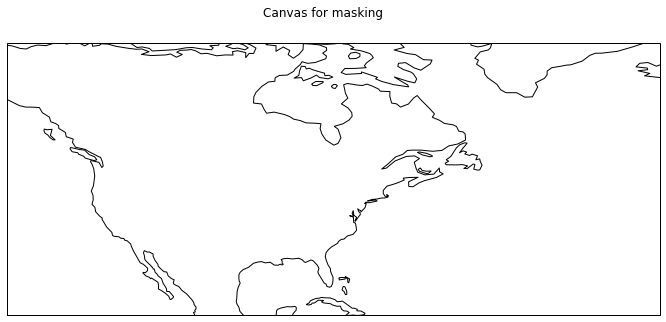

In [75]:
extents = [lon0,lon1,lat0,lat1]
extents = [item if item < 180 else item-360 for item in extents]
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.imshow(np.zeros((10,10)),extent=extents, cmap='gray_r')
ax.coastlines()
fig.suptitle('Canvas for masking')
plt.show()

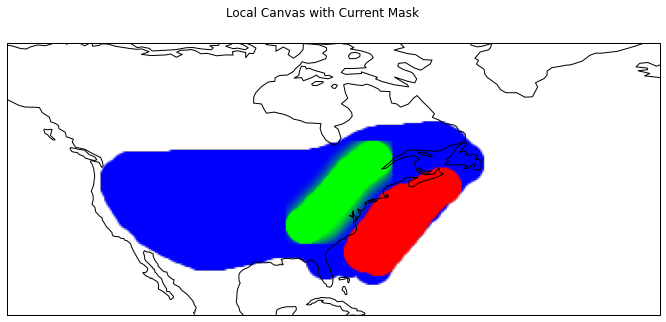

In [70]:
img = imread(MASK_PATH)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.imshow(img[::-1],extent=(-140,-20,20,70), cmap='gray_r')
ax.coastlines()
fig.suptitle('Local Canvas with Current Mask')
plt.show()

In [53]:
def retrieve_loc_data(path, lon0, lon1, lat0, lat1, return_times=False):
    
    fh = Dataset(path, mode='r')
    lons = fh.variables['lon'][:].data
    lats = fh.variables['lat'][:].data
    
    if 'uwnd' in path:
        name = 'uwnd'
    else:
        name = 'vwnd'
    
    data = fh.variables[name][:].data
    
    times = fh.variables['time'][:].data
    times = cft.num2pydate(times, fh.variables['time'].units, calendar='standard')
                
    lat_mask = ((lats >= lat0) & (lats <= lat1))

    lon_mask = ((lons >= lon0) & (lons <= lon1))

    start_lat = np.argwhere(lat_mask).min()
    end_lat = np.argwhere(lat_mask).max()

    start_lon = np.argwhere(lon_mask).min()
    end_lon = np.argwhere(lon_mask).max()

    loc_data = data[..., start_lat:end_lat+1, start_lon:end_lon+1]
    
    if return_times:
        return times, loc_data
    
    return loc_data

def get_score(u, v, r_u, r_v, norm_mask, pos_mask, neg_mask):
    global DIRECTION_WEIGHT, INTENSITY_WEIGHT, NEG_MASK_WEIGHT
    
    direction_weight = DIRECTION_WEIGHT
    intensity_weight = INTENSITY_WEIGHT
    neg_mask_weight = NEG_MASK_WEIGHT
    
    u = u[:]*norm_mask
    u = normalize(u[:])/np.sqrt(2)
    u_pos = u[:]*pos_mask
    
    v = v[:]*norm_mask
    v = normalize(v[:])/np.sqrt(2)
    v_pos = v[:]*pos_mask
    
    r_u = r_u[:]*pos_mask
    r_v = r_v[:]*pos_mask
    
    # Get angle Score
    cur_angles = np.zeros(u.shape)
    np.arctan2(v_pos,u_pos,out=cur_angles,where=v_pos!=0)
    cur_angles = np.rad2deg(cur_angles)
    cur_angles[cur_angles < 0] = 360 + cur_angles[cur_angles < 0]
    
    ref_angles = np.zeros(r_u.shape)
    np.arctan2(r_v,r_u, out=ref_angles, where=r_v!=0)
    ref_angles = np.rad2deg(ref_angles)
    
    angle_diff = np.abs(ref_angles-cur_angles)
    angle_diff[angle_diff > 180] = angle_diff[angle_diff > 180] - 180
    angle_diff = angle_diff/180 # From 0-180 to 0-1
    angle_error = (angle_diff*pos_mask).sum()/(pos_mask.sum())
    
    # Intensity Score
    diff = 1-np.sqrt(np.square(u) + np.square(v))
    intensity_error = (diff*pos_mask).sum()/(pos_mask.sum())
    
    # Negative Mask
    v_mag = np.sqrt(np.square(u) + np.square(v))
    neg_mask_error = (v_mag*neg_mask).sum()/(neg_mask.sum())
    
    weighted_score = direction_weight*(1-angle_error) + intensity_weight*(1-intensity_error) + neg_mask_weight*(1-neg_mask_error)
    # Weight each score
    return np.power(weighted_score, 2)

In [76]:
img = imread(MASK_PATH)

gray_img = imread(MASK_PATH, as_gray=True) # Grayscale image to normalize data to
norm_mask = gray_img.copy()
norm_mask[norm_mask > 0.01] = 1

pos_mask = img[...,1].copy() # Green color channel corresponds to positive mask
neg_mask = img[...,0].copy() # Red color channel corresponds to negative mask

# Take random data sample to format/shape masks
for _,_,filenames in os.walk(os.path.join(DATA_ROOT,'u_winds')):
    rand_filename = filenames[0]

rand_data_path = os.path.join(DATA_ROOT,'u_winds',rand_filename)
rand_data = retrieve_loc_data(rand_data_path,lon0,lon1,lat0,lat1)

norm_mask = resize(norm_mask, rand_data.shape[-2:])
pos_mask = resize(pos_mask, rand_data.shape[-2:])
neg_mask = resize(neg_mask, rand_data.shape[-2:])

ref_angle = REF_ANGLE
ref_u = np.ones(rand_data.shape[-2:])*np.cos(np.deg2rad(ref_angle))
ref_v = np.ones(rand_data.shape[-2:])*np.sin(np.deg2rad(ref_angle))

# Iterate through Data and Assign Scores

In [5]:
scores = []

level = 6
start_year = START_YEAR
end_year = END_YEAR + 1

# for year in years:
for year in range(start_year, end_year):

    uwnd_path = os.path.join(DATA_ROOT,"u_winds",f'uwnd.{year}.nc')
    vwnd_path = os.path.join(DATA_ROOT,"v_winds",f'vwnd.{year}.nc')
    # retrieve data
    try:
        times, uwnds = retrieve_loc_data(uwnd_path,lon0,lon1,lat0,lat1, return_times=True)
        vwnds = retrieve_loc_data(vwnd_path,lon0,lon1,lat0,lat1)
    except:
        logging.info(f'Insufficient Data found for {year}')
        continue
    
    
    # for day in range(days):
    for day in range(uwnds.shape[0]):
        
        cur_u_winds = uwnds[day, level-1]
        cur_v_winds = vwnds[day, level-1]

        # scores[year].append(get_score(day))
        score = get_score(cur_u_winds, cur_v_winds, ref_u, ref_v, norm_mask, pos_mask, neg_mask)

        time = times[day]
        scores.append([time,score])


    time_now = datetime.datetime.now().strftime(r"%H:%M:%S")
    logging.info(f'  {time_now}  -  Year {year} Complete')

INFO:root:  14:08:49  -  Year 1979 Complete
INFO:root:  14:08:58  -  Year 1980 Complete
INFO:root:  14:09:07  -  Year 1981 Complete
INFO:root:  14:09:15  -  Year 1982 Complete
INFO:root:  14:09:24  -  Year 1983 Complete
INFO:root:  14:09:33  -  Year 1984 Complete
INFO:root:  14:09:42  -  Year 1985 Complete
INFO:root:  14:09:50  -  Year 1986 Complete
INFO:root:  14:09:59  -  Year 1987 Complete
INFO:root:  14:10:07  -  Year 1988 Complete
INFO:root:  14:10:16  -  Year 1989 Complete
INFO:root:  14:10:24  -  Year 1990 Complete
INFO:root:  14:10:33  -  Year 1991 Complete
INFO:root:  14:10:41  -  Year 1992 Complete
INFO:root:  14:10:50  -  Year 1993 Complete
INFO:root:  14:10:59  -  Year 1994 Complete
INFO:root:  14:11:07  -  Year 1995 Complete
INFO:root:  14:11:16  -  Year 1996 Complete
INFO:root:  14:11:24  -  Year 1997 Complete
INFO:root:  14:11:33  -  Year 1998 Complete
INFO:root:  14:11:41  -  Year 1999 Complete
INFO:root:  14:11:50  -  Year 2000 Complete
INFO:root:  14:11:59  -  Year 20

# Organize Results

In [6]:
df = pd.DataFrame(scores, columns = ['date','score'])
n = 20
df_top = df.sort_values('score', ascending=False).head(n)
df_top.head()

,date,score
315,1979-11-12,0.770465
13598,2016-03-25,0.760101
1130,1982-02-04,0.759934
314,1979-11-11,0.756623
55,1979-02-25,0.755958


In [77]:
# Calling Matches object created in DataMatching.py
matches = Matches(r"E:\WeatherData",df_top)

(<Figure size 1080x288 with 4 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x0000023EA2E47808>,
       dtype=object))

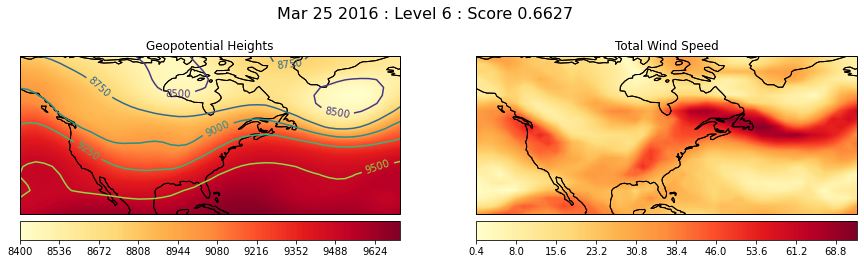

In [30]:
matches.plot('all',1,6)

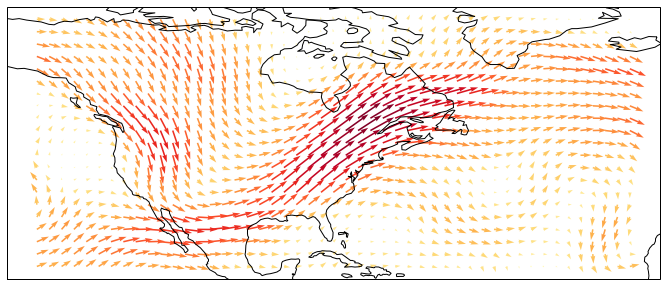

In [14]:
fig, ax = matches.quiver(5,6)

In [8]:
df.sort_values('score', ascending=False).to_csv('scores_7_8.csv',index=False)

Text(0.5, 1.0, 'Score Distribution')

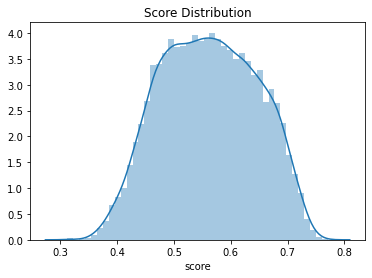

In [78]:
sns.distplot(df['score'])
plt.title('Score Distribution')